# Part 4, Model 1A NN: Basic Glaucoma Detection using MobileNetV3 neural network

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler  # Fix import statement
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

from pathlib import Path

#import useful module for keras library
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

# get modules from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-02-17 14:54:37.721050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 14:54:37.721116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 14:54:37.811859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 14:54:37.984563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-17 14:54:39.636672: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data[data['fundus_oc_seg'].notnull() & data['fundus_od_seg'].notnull()].info()

print(data['fundus_oc_seg'].notnull().value_counts())

data[data['fundus_oc_seg'].notnull()]

<class 'pandas.core.frame.DataFrame'>
Index: 3102 entries, 4546 to 12048
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     3102 non-null   object 
 1   types                     3102 non-null   int64  
 2   type_expanded             1848 non-null   object 
 3   isColor                   3102 non-null   int64  
 4   original_name             3102 non-null   object 
 5   patient_id                488 non-null    object 
 6   fundus                    3102 non-null   object 
 7   fundus_od_seg             3102 non-null   object 
 8   fundus_oc_seg             3102 non-null   object 
 9   bv_seg                    0 non-null      object 
 10  artery_seg                0 non-null      object 
 11  vein_seg                  0 non-null      object 
 12  oct                       44 non-null     object 
 13  oct_oc_seg                44 non-null     object 
 14  oct_od_se

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
4546,ORIGA-1,0,NaN,1,001.jpg,NaN,/full-fundus/ORIGA-1.png,/optic-disc/ORIGA-1.png,/optic-cup/ORIGA-1.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547,ORIGA-2,0,NaN,1,002.jpg,NaN,/full-fundus/ORIGA-2.png,/optic-disc/ORIGA-2.png,/optic-cup/ORIGA-2.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4548,ORIGA-3,0,NaN,1,003.jpg,NaN,/full-fundus/ORIGA-3.png,/optic-disc/ORIGA-3.png,/optic-cup/ORIGA-3.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4549,ORIGA-4,0,NaN,1,004.jpg,NaN,/full-fundus/ORIGA-4.png,/optic-disc/ORIGA-4.png,/optic-cup/ORIGA-4.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4550,ORIGA-5,0,NaN,1,005.jpg,NaN,/full-fundus/ORIGA-5.png,/optic-disc/ORIGA-5.png,/optic-cup/ORIGA-5.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,PAPILA-484,0,Healthy,1,289,PAPILA-289,/full-fundus/PAPILA-484.png,/optic-disc/PAPILA-484.png,/optic-cup/PAPILA-484.png,NaN,...,NaN,0.75,-1.5,93,1,10,,531,22.31,
12045,PAPILA-485,0,Healthy,1,290,PAPILA-290,/full-fundus/PAPILA-485.png,/optic-disc/PAPILA-485.png,/optic-cup/PAPILA-485.png,NaN,...,NaN,0.25,-0.25,160,1,19,,573,22.01,
12046,PAPILA-486,0,Healthy,1,291,PAPILA-291,/full-fundus/PAPILA-486.png,/optic-disc/PAPILA-486.png,/optic-cup/PAPILA-486.png,NaN,...,NaN,1.5,-1.25,76,0,14,,443,23.51,
12047,PAPILA-487,0,Healthy,1,292,PAPILA-292,/full-fundus/PAPILA-487.png,/optic-disc/PAPILA-487.png,/optic-cup/PAPILA-487.png,NaN,...,NaN,1.25,-0.75,79,0,9,,479,23.84,


In [8]:
# know column type
data['fundus_oc_seg'].dtype

dtype('O')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [10]:
data['fundus_oc_seg'][12044]

'/optic-cup/PAPILA-484.png'

In [11]:
data['fundus_od_seg'][12044]

'/optic-disc/PAPILA-484.png'

In [12]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


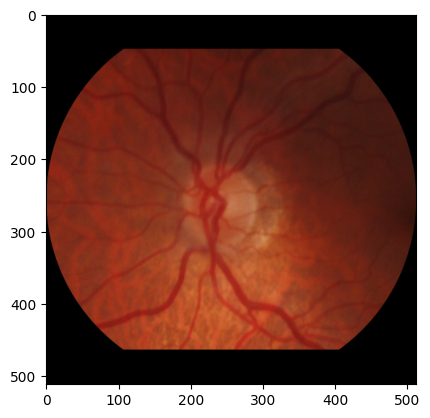

optic-cup/optic-cup/PAPILA-484.png


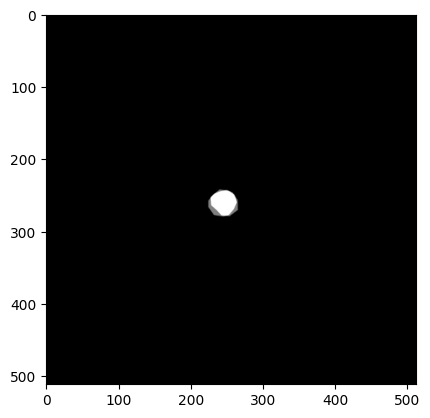

In [13]:
import os
import random

def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()


viewFundus(data['fundus'][12044])
viewOpticCup(data['fundus_oc_seg'][12044])

In [14]:
data["types"].value_counts()

types
 0    7549
 1    4767
-1     133
Name: count, dtype: int64

In [15]:
data["types"].value_counts().sum()

12449

In [16]:
#removing the patients with no fundus classification and with fundus classification -1 instead of 0,1
fundus_subset = data[(data['fundus'].notnull()) & (data['types'] != -1)]

fundus_subset = fundus_subset[['types', 'fundus', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   types     12316 non-null  object
 1   fundus    12316 non-null  object
 2   names     12316 non-null  object
 3   combined  12316 non-null  object
dtypes: object(4)
memory usage: 481.1+ KB


In [17]:
fundus_subset['types'].value_counts()

types
0    7549
1    4767
Name: count, dtype: int64

In [18]:
fundus_subset

,types,fundus,names,combined
0,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,OIA-ODIR-TEST-OFFLINE-1,OIA-ODIR-TEST-OFFLINE-1.png
1,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,OIA-ODIR-TEST-OFFLINE-2,OIA-ODIR-TEST-OFFLINE-2.png
2,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,OIA-ODIR-TEST-OFFLINE-4,OIA-ODIR-TEST-OFFLINE-4.png
3,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,OIA-ODIR-TEST-OFFLINE-5,OIA-ODIR-TEST-OFFLINE-5.png
4,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,OIA-ODIR-TEST-OFFLINE-6,OIA-ODIR-TEST-OFFLINE-6.png
...,...,...,...,...
12444,0,/full-fundus/FIVES-396.png,FIVES-396,FIVES-396.png
12445,0,/full-fundus/FIVES-397.png,FIVES-397,FIVES-397.png
12446,0,/full-fundus/FIVES-398.png,FIVES-398,FIVES-398.png
12447,0,/full-fundus/FIVES-399.png,FIVES-399,FIVES-399.png


In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming fundus_subset is your DataFrame and 'types' is the column with labels
# Also assuming you have 'fundus_subset_random' DataFrame created earlier

testSize = 500
valSize = 500

# Calculate the number of samples for each class
glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

print('Total fundus images to  be used: ', glaucomaCount + healthyCount)

# Set the random seed for reproducibility
random_state = 1

# Create StratifiedShuffleSplit instance for test set
stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

# Create StratifiedShuffleSplit instance for validation set
stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=valSize, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set, train_set['types']):
    train = train_set.iloc[train_index]
    val = train_set.iloc[val_index]

# Now train_set_final, val_set, and test_set contain the stratified splits

# Print the counts for each set
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

# You can access the features and labels as needed:
train_features = train.drop('types', axis=1)  # assuming 'types' is the label column
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 4767
this is the healthy eyes count 7549
Total fundus images to  be used:  12316

Train set size: 11316
Validation set size: 500
Test set size: 500


In [20]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  11316
Test Size:  500


In [34]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [35]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 


# Set target size and batch size for data generator
target = 512
batchSize = 16

# Set the class mode to 'binary' for training data generator
classes = 'binary'

with tf.device('/GPU:0'):


    # Create the training data generator
    trainDataGen = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
)
    trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    # Create the validation data generator
    valDataGen = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
)
    valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    # Create the testing data generator
    testDataGen = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
)
    testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 11316 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [36]:
# randomize data
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# create df for each class based on randomized data
healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1']

with tf.device('/GPU:0'):

    # Set class mode to 'sparse' for visualization data generators
    classes = 'sparse'

    # Create data generators for healthy and glaucoma subsets for visualization
    healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    healthy_subset_Gen = healthy_subsetDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = 8, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(224, 224), 
                                                color_mode='rgb')


    glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = 8, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(224, 224), 
                                                color_mode='rgb')

Found 7549 validated image filenames belonging to 1 classes.
Found 4767 validated image filenames belonging to 1 classes.


In [37]:
def show_images(gen):
    
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

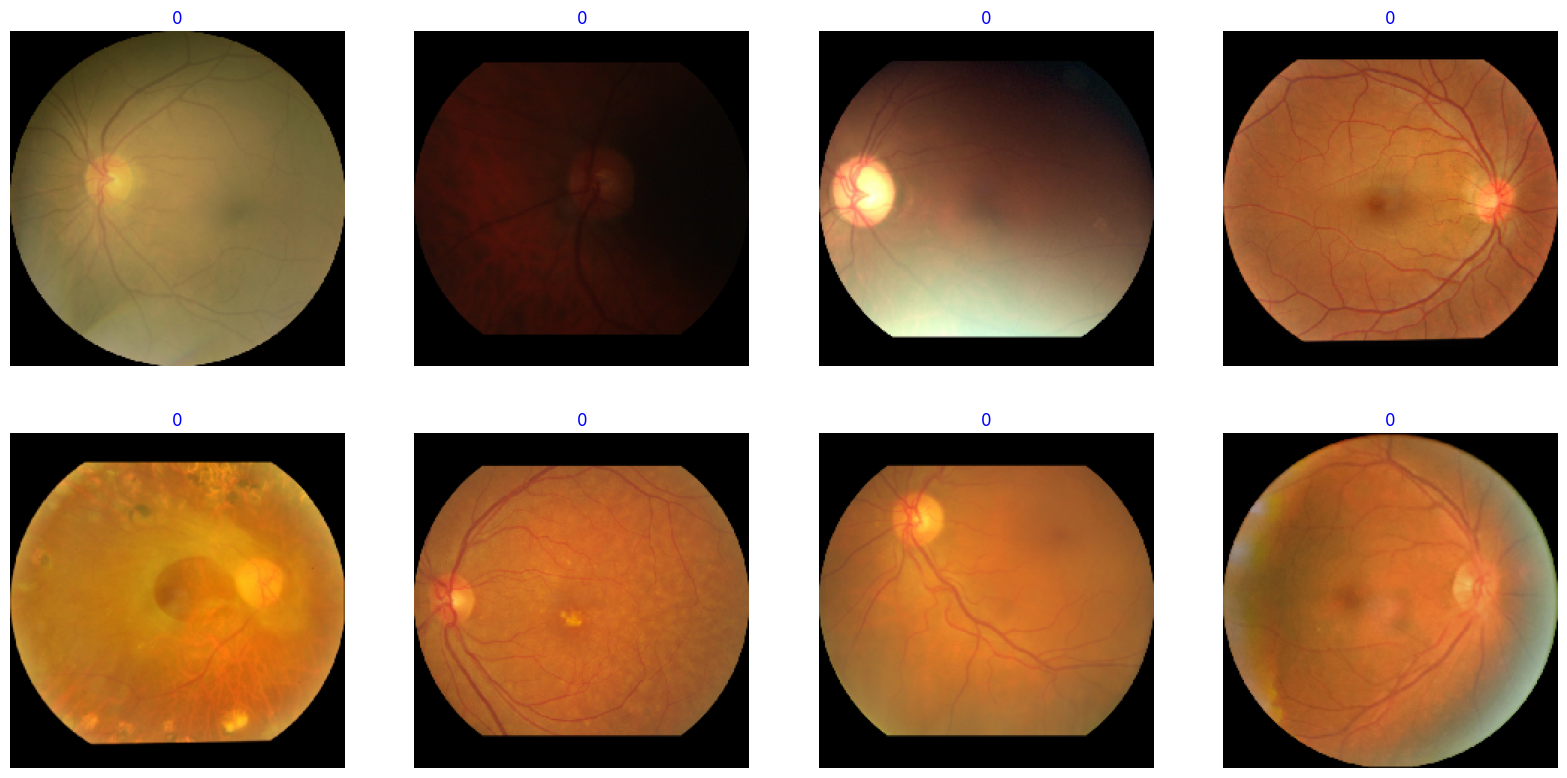

In [38]:
show_images(healthy_subset_Gen)

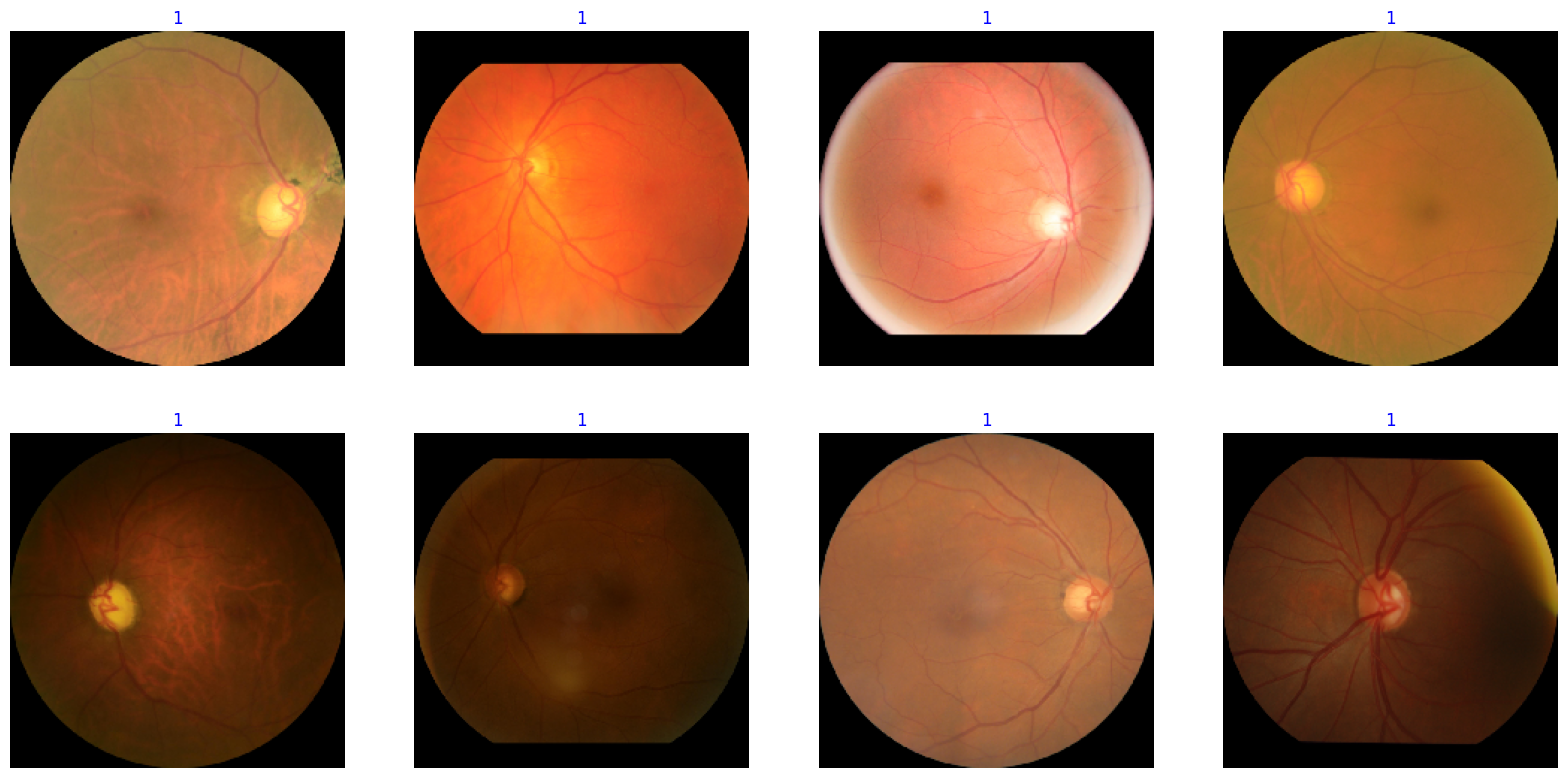

In [39]:
show_images(glaucoma_subset_Gen)

In [40]:
# import tensorflow as tf
# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from keras.optimizers import Adam

# # Define the model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')  # Binary output
# ])

# # Compile the model
# model.compile(optimizer=Adam(lr=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# model.summary()

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model with a learning rate schedule
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Add callbacks for early stopping and model checkpoints
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 510, 510, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 253, 253, 64)      256       
 chNormalization)                                                
                                                        

In [41]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:

with tf.device('/GPU:0'):
    
    history = model.fit(
      trainGen,
      steps_per_epoch=100,
      epochs=15,
      validation_data=valGen,
      validation_steps=50,
      verbose=2
    )

Epoch 1/50


2024-02-17 15:31:18.454238: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11851097224963842262
2024-02-17 15:31:18.454302: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15605970901201842060



Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to best_model.h5


/root/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 - 120s - loss: 0.7897 - accuracy: 0.5881 - val_loss: 0.6920 - val_accuracy: 0.4800 - 120s/epoch - 1s/step
Epoch 2/50


100/100 - 81s - loss: 0.7987 - accuracy: 0.5638 - 81s/epoch - 813ms/step
Epoch 3/50


100/100 - 84s - loss: 0.7852 - accuracy: 0.5619 - 84s/epoch - 841ms/step
Epoch 4/50


100/100 - 85s - loss: 0.7333 - accuracy: 0.6152 - 85s/epoch - 847ms/step
Epoch 5/50


100/100 - 84s - loss: 0.7531 - accuracy: 0.6006 - 84s/epoch - 843ms/step
Epoch 6/50


100/100 - 85s - loss: 0.7234 - accuracy: 0.6052 - 85s/epoch - 852ms/step
Epoch 7/50


100/100 - 86s - loss: 0.7321 - accuracy: 0.6131 - 86s/epoch - 864ms/step
Epoch 8/50


100/100 - 87s - loss: 0.7145 - accuracy: 0.6269 - 87s/epoch - 873ms/step
Epoch 9/50


100/100 - 88s - loss: 0.7296 - accuracy: 0.6119 - 88s/epoch - 879ms/step
Epoch 10/50


100/100 - 94s - loss: 0.7352 - accuracy: 0.6134 - 94s/epoch - 936ms/step
Epoch 11/50


100/100 - 89s - loss: 0.7202 - accuracy: 0.6212 - 89s/epoch - 894ms/step
Epoch 12/50


100/100 - 91s - loss: 0.7022 - accuracy: 0.6469 - 91s/epoch - 911ms/step
Epoch 13/50


100/100 - 85s - loss: 0.7149 - accuracy: 0.6137 - 85s/epoch - 846ms/step
Epoch 14/50


100/100 - 90s - loss: 0.7012 - accuracy: 0.6212 - 90s/epoch - 900ms/step
Epoch 15/50


100/100 - 85s - loss: 0.7044 - accuracy: 0.6256 - 85s/epoch - 848ms/step
Epoch 16/50


100/100 - 84s - loss: 0.7035 - accuracy: 0.6263 - 84s/epoch - 838ms/step
Epoch 17/50


100/100 - 82s - loss: 0.7066 - accuracy: 0.6256 - 82s/epoch - 818ms/step
Epoch 18/50


100/100 - 82s - loss: 0.7023 - accuracy: 0.6344 - 82s/epoch - 822ms/step
Epoch 19/50


100/100 - 89s - loss: 0.7242 - accuracy: 0.6100 - 89s/epoch - 893ms/step
Epoch 20/50


100/100 - 97s - loss: 0.6651 - accuracy: 0.6538 - 97s/epoch - 967ms/step
Epoch 21/50


100/100 - 96s - loss: 0.7068 - accuracy: 0.6150 - 96s/epoch - 957ms/step
Epoch 22/50


100/100 - 104s - loss: 0.6601 - accuracy: 0.6400 - 104s/epoch - 1s/step
Epoch 23/50


100/100 - 89s - loss: 0.6853 - accuracy: 0.6419 - 89s/epoch - 892ms/step
Epoch 24/50


100/100 - 80s - loss: 0.6911 - accuracy: 0.6319 - 80s/epoch - 795ms/step
Epoch 25/50


100/100 - 89s - loss: 0.6696 - accuracy: 0.6425 - 89s/epoch - 891ms/step
Epoch 26/50


100/100 - 103s - loss: 0.6477 - accuracy: 0.6687 - 103s/epoch - 1s/step
Epoch 27/50


100/100 - 102s - loss: 0.6736 - accuracy: 0.6488 - 102s/epoch - 1s/step
Epoch 28/50


100/100 - 102s - loss: 0.6837 - accuracy: 0.6356 - 102s/epoch - 1s/step
Epoch 29/50


100/100 - 108s - loss: 0.6560 - accuracy: 0.6538 - 108s/epoch - 1s/step
Epoch 30/50


100/100 - 96s - loss: 0.6903 - accuracy: 0.6356 - 96s/epoch - 961ms/step
Epoch 31/50


100/100 - 97s - loss: 0.6471 - accuracy: 0.6707 - 97s/epoch - 971ms/step
Epoch 32/50


100/100 - 81s - loss: 0.6876 - accuracy: 0.6288 - 81s/epoch - 814ms/step
Epoch 33/50


100/100 - 82s - loss: 0.6498 - accuracy: 0.6581 - 82s/epoch - 819ms/step
Epoch 34/50


100/100 - 80s - loss: 0.6372 - accuracy: 0.6756 - 80s/epoch - 804ms/step
Epoch 35/50


100/100 - 82s - loss: 0.6621 - accuracy: 0.6531 - 82s/epoch - 819ms/step
Epoch 36/50


100/100 - 83s - loss: 0.6829 - accuracy: 0.6413 - 83s/epoch - 834ms/step
Epoch 37/50


100/100 - 84s - loss: 0.6709 - accuracy: 0.6511 - 84s/epoch - 838ms/step
Epoch 38/50


100/100 - 85s - loss: 0.6598 - accuracy: 0.6587 - 85s/epoch - 846ms/step
Epoch 39/50


100/100 - 88s - loss: 0.6598 - accuracy: 0.6475 - 88s/epoch - 877ms/step
Epoch 40/50


100/100 - 85s - loss: 0.6687 - accuracy: 0.6506 - 85s/epoch - 849ms/step
Epoch 41/50


100/100 - 84s - loss: 0.6707 - accuracy: 0.6438 - 84s/epoch - 840ms/step
Epoch 42/50


100/100 - 84s - loss: 0.6734 - accuracy: 0.6431 - 84s/epoch - 836ms/step
Epoch 43/50


100/100 - 84s - loss: 0.6613 - accuracy: 0.6444 - 84s/epoch - 836ms/step
Epoch 44/50


100/100 - 83s - loss: 0.6677 - accuracy: 0.6297 - 83s/epoch - 830ms/step
Epoch 45/50


100/100 - 83s - loss: 0.6521 - accuracy: 0.6474 - 83s/epoch - 834ms/step
Epoch 46/50


100/100 - 84s - loss: 0.6310 - accuracy: 0.6694 - 84s/epoch - 842ms/step
Epoch 47/50


100/100 - 84s - loss: 0.6369 - accuracy: 0.6644 - 84s/epoch - 843ms/step
Epoch 48/50


100/100 - 83s - loss: 0.6340 - accuracy: 0.6681 - 83s/epoch - 834ms/step
Epoch 49/50


100/100 - 84s - loss: 0.6582 - accuracy: 0.6404 - 84s/epoch - 835ms/step
Epoch 50/50


100/100 - 86s - loss: 0.6513 - accuracy: 0.6594 - 86s/epoch - 862ms/step


In [43]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(valGen)
print('Validation accuracy:', val_accuracy)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(testGen)
print('Test accuracy:', test_accuracy)

32/32 [==============================] - 42s 1s/step - loss: 0.5882 - accuracy: 0.6920
Validation accuracy: 0.6919999718666077
32/32 [==============================] - 26s 803ms/step - loss: 0.5914 - accuracy: 0.6680
Test accuracy: 0.6679999828338623


In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming test_generator has shuffle=False
# Predict classes on the test set
test_predictions_prob = model.predict(testGen)
# Convert probabilities to class labels based on a threshold (e.g., 0.5 for binary classification)
test_predictions = np.where(test_predictions_prob > 0.5, 1, 0)

# Since test_generator.classes provides the true labels, we can use it directly
true_labels = testGen.classes

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, test_predictions)
class_report = classification_report(true_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

32/32 [==============================] - 32s 987ms/step
Confusion Matrix:
[[246  60]
 [ 95  99]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       306
           1       0.62      0.51      0.56       194

    accuracy                           0.69       500
   macro avg       0.67      0.66      0.66       500
weighted avg       0.68      0.69      0.68       500

